In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-10-23 08:54:16.137790: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-23 08:54:16.238635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-23 08:54:16.238672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-23 08:54:16.251354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-23 08:54:16.281458: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Load training info

In [3]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_p5_n10000'
tag_Anoise = '_An_p1_n10000'

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [4]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

## Inference results: nbar=0.00011

In [11]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00011'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_noise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

0.00011 1.414213562373095
[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47409821
  0.06306578 -0.17022439 -0.83432633  1.41421356]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'A_noise']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_nbar0.00011_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_bispec_nbar0.00011_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_bispec_nbar0.00011_pred.npy


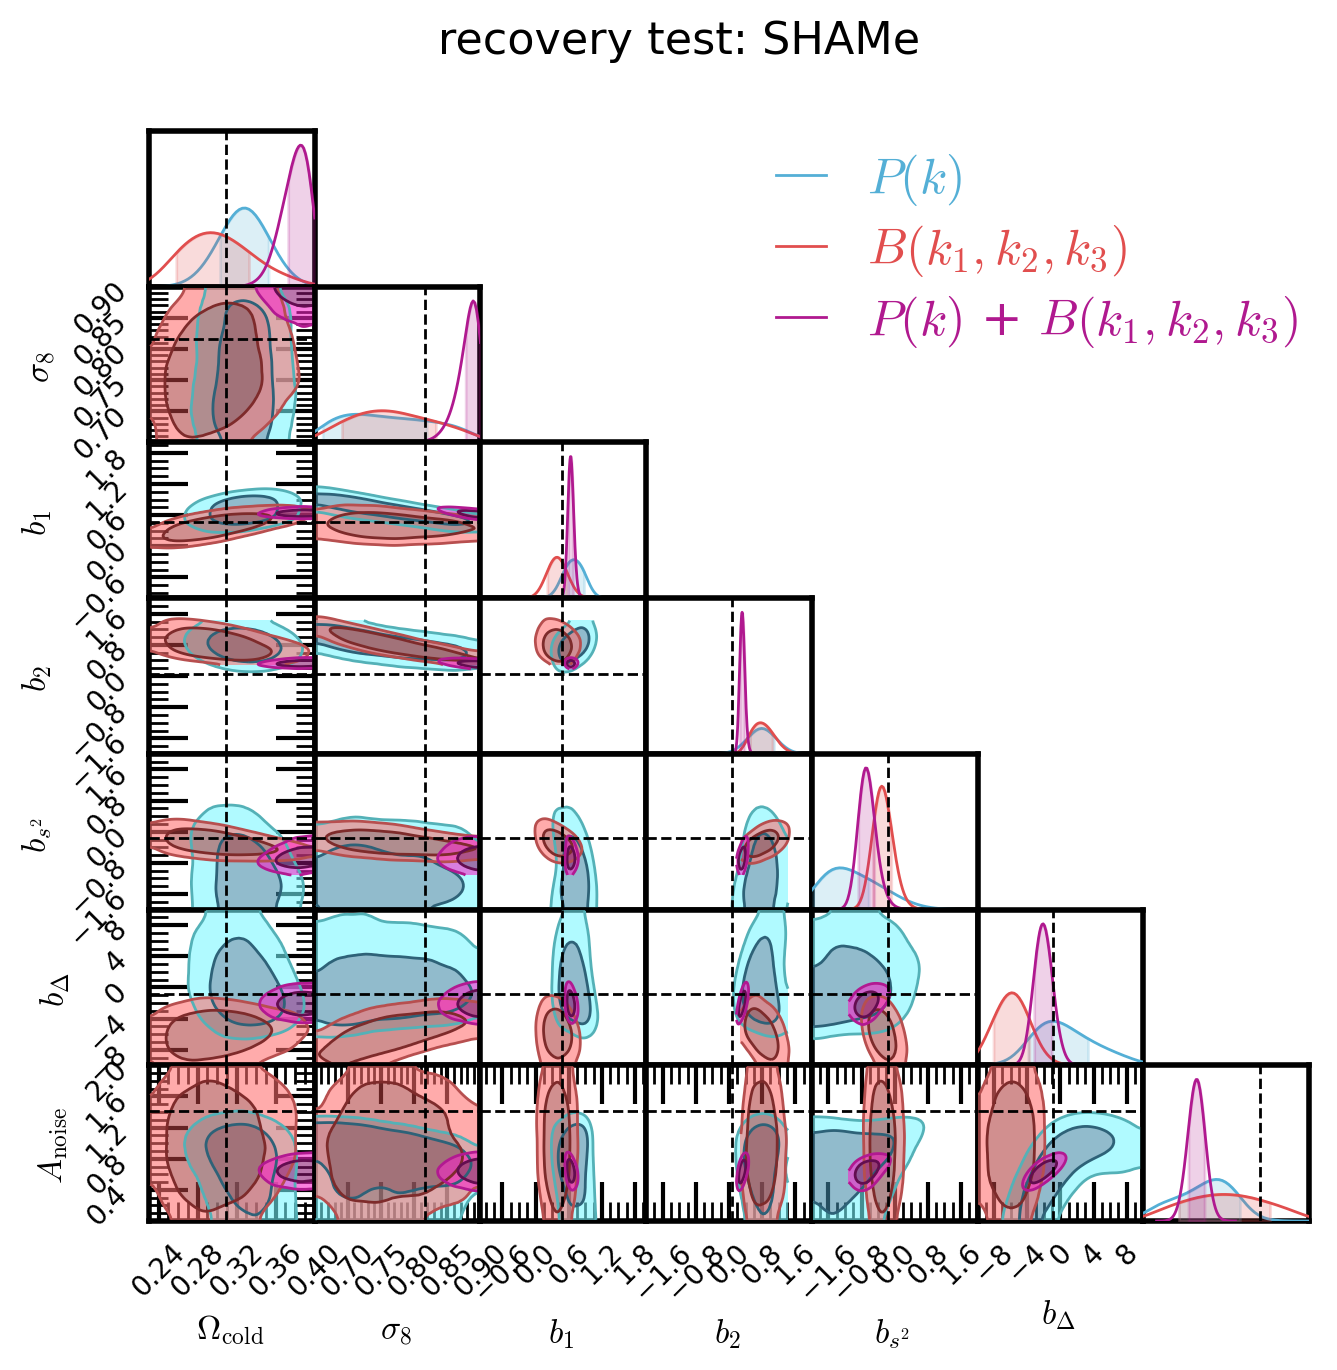

In [12]:
print(param_names_vary)
idx_obs = 0
title = 'recovery test: SHAMe'
tags_test = ['_'+data_mode_test + tag_stats + tag_mock for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## Inference results: nbar=0.00022

In [15]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_An1'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_noise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47409821
  0.06306578 -0.17022439 -0.83432633  1.        ]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'A_noise']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_An1_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_bispec_An1_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_bispec_An1_pred.npy


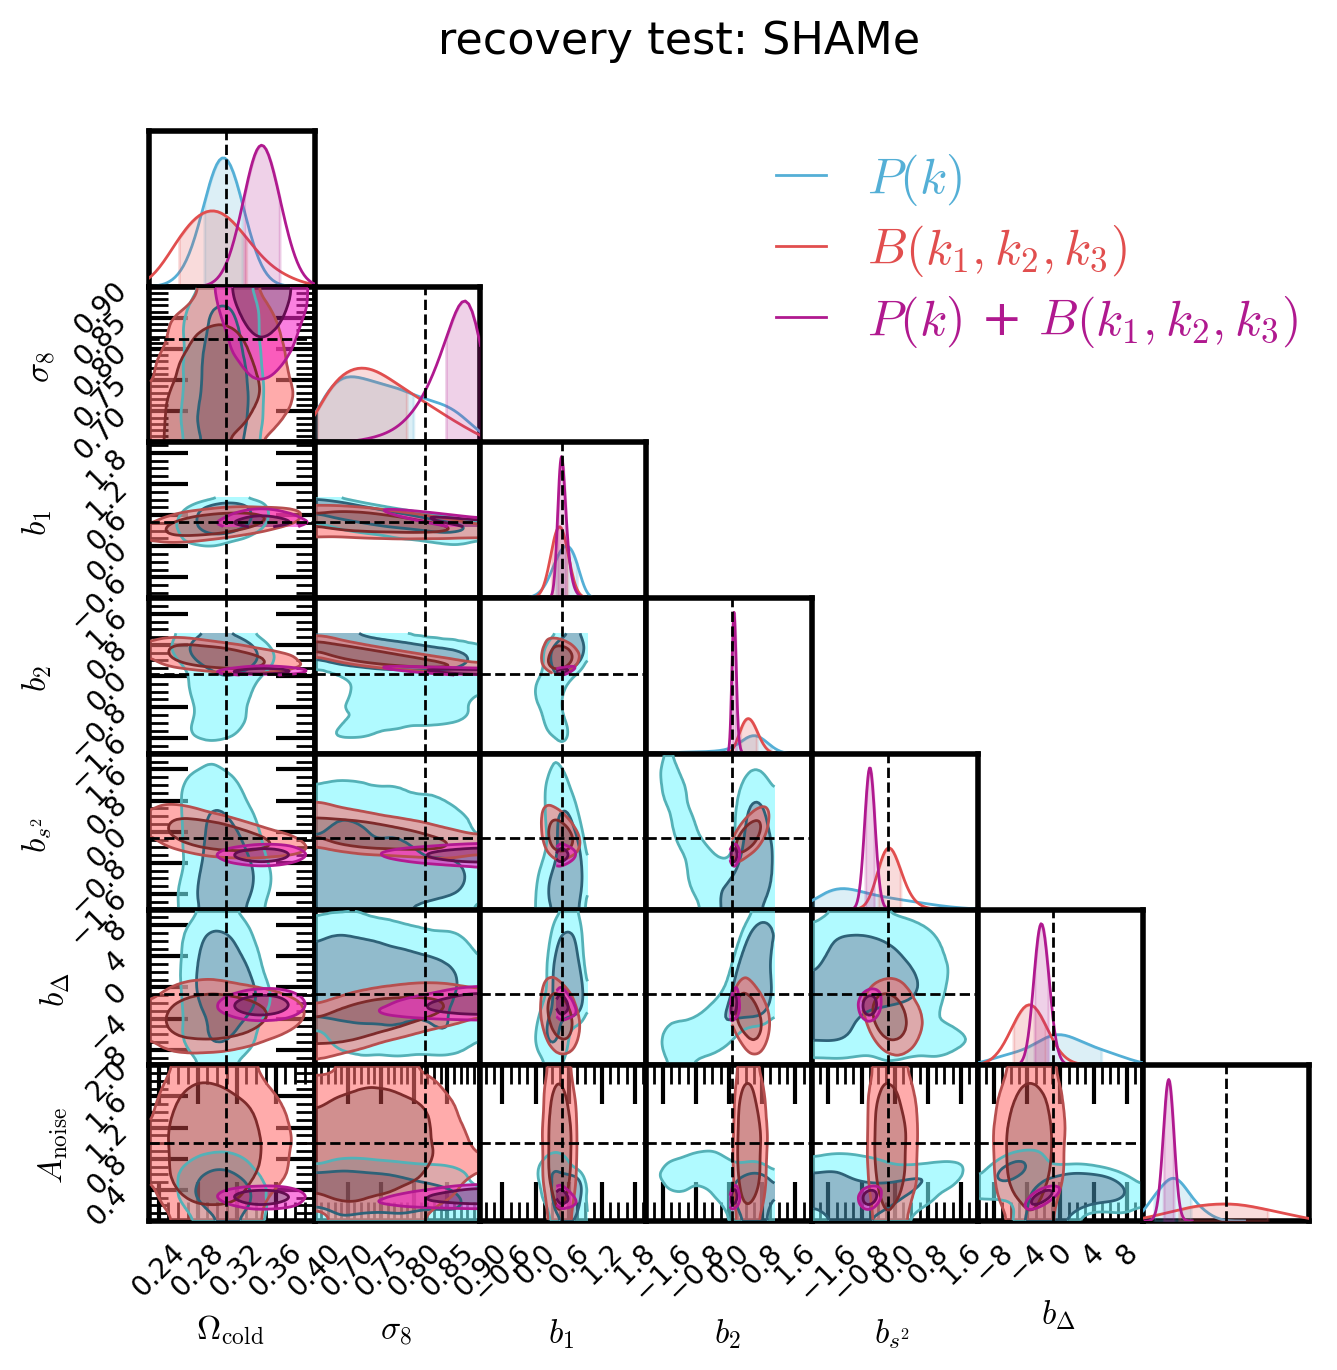

In [16]:
print(param_names_vary)
idx_obs = 0
title = 'recovery test: SHAMe'
tags_test = ['_'+data_mode_test + tag_stats + tag_mock for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## Inference results: nbar=0.00054

In [13]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00054'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_noise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

0.00054 0.6382847385042254
[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47409821
  0.06306578 -0.17022439 -0.83432633  0.63828474]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'A_noise']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_nbar0.00054_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_bispec_nbar0.00054_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_p5_n10000_An_p1_n10000_ntrain10000/samples_test_shame_pk_bispec_nbar0.00054_pred.npy


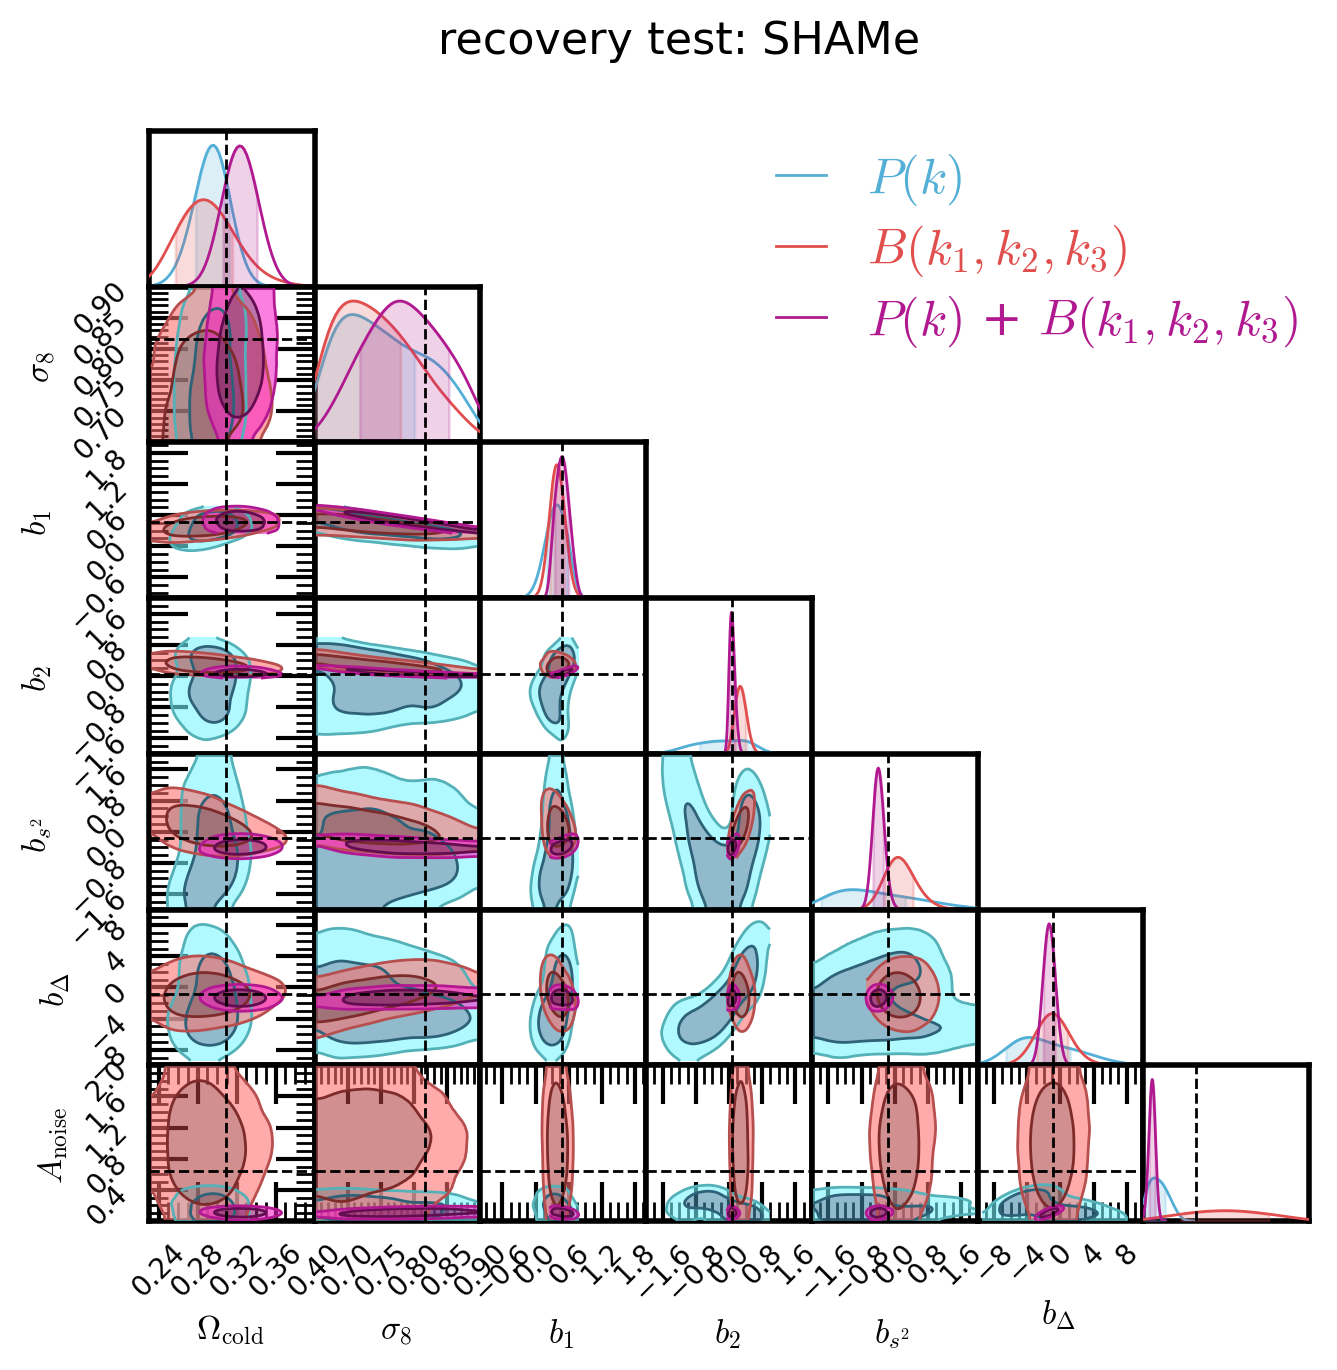

In [14]:
print(param_names_vary)
idx_obs = 0
title = 'recovery test: SHAMe'
tags_test = ['_'+data_mode_test + tag_stats + tag_mock for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## Load catalogs

In [29]:
def compute_pk(tracer_field, cosmo, box_size,
               log_binning=True,
               normalise_grid=False, deconvolve_grid=False,
               interlacing=False, deposit_method='cic',
               correct_grid=False,
               n_threads=8, fn_stat=None):

    k_min = 0.01
    k_max = 1.0
    n_bins = 60
    
    # NOTE by default assumes tracer field is already normalized!

    # n_grid has to match the tracer field size for this compuation!
    n_grid = tracer_field.shape[-1]
    print("Computing pk, using n_grid = ", n_grid, flush=True)

    # defaults from bacco.statistics.compute_crossspectrum_twogrids
    # unless passed or otherwise denoted
    args_power_grid = {
        # "grid1": None,
        # "grid2": None,
        "normalise_grid1": normalise_grid, #default: False
        "normalise_grid2": normalise_grid, #default: False
        "deconvolve_grid1": deconvolve_grid, #default: False
        "deconvolve_grid2": deconvolve_grid, #default: False
        "ngrid": n_grid,
        "box": box_size,
        "mass1": None,
        "mass2": None,
        "interlacing": interlacing, #default: True
        "deposit_method": deposit_method, #default: "tsc",
        "log_binning": log_binning,
        "pk_lt": None,
        "kmin": k_min,
        "kmax": k_max,
        "nbins": n_bins,
        "correct_grid": correct_grid,
        "zspace": False,
        "cosmology": cosmo,
        "pmulti_interp": "polyfit",
        "nthreads": n_threads,
        "compute_correlation": False, #default: True
        "compute_power2d": False, #default: True
        "folds": 1,
        "totalmass1": None,
        "totalmass2": None,
        "jack_error": False,
        "n_jack": None
    }

    pknbody_dict = {
        'ngrid': n_grid,
        'min_k': k_min,
        'log_binning': log_binning,
        'log_binning_kmax': k_max,
        'log_binning_nbins': n_bins,
        'interlacing': interlacing,
        'depmethod': deposit_method,
        'correct_grid': correct_grid,
        'folds': 1 #default
    }
    bacco.configuration.update({'number_of_threads': n_threads})
    bacco.configuration.update({'pknbody': pknbody_dict})
    bacco.configuration.update({'pk' : {'maxk' : k_max}})
    bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})

    pk_obj = bacco.statistics.compute_crossspectrum_twogrids(
                        grid1=tracer_field,
                        grid2=tracer_field,
                        **args_power_grid)
    
    if fn_stat is not None:
        Path.absolute(Path(fn_stat).parent).mkdir(parents=True, exist_ok=True)
        np.save(fn_stat, pk_obj)
        
    return pk_obj

In [24]:
box_size_mock = 1024.0  # Mpc/h
cosmo = utils.get_cosmo(utils.cosmo_dict_shame)

In [39]:
data_mode = 'shame'

tags_mock = ['_nbar0.00011', '_An1', '_nbar0.00054']
pk_obj_arr = []
for tag_mock in tags_mock:

    fn_cat0_mesh = f'../data/data_{data_mode}/data{tag_mock}/tracer_field_phase0.npy'
    fn_catpi_mesh = f'../data/data_{data_mode}/data{tag_mock}/tracer_field_phasepi.npy'
    tracer_field_0 = np.load(fn_cat0_mesh, allow_pickle=True)
    tracer_field_pi = np.load(fn_catpi_mesh, allow_pickle=True)
    
    pk_obj_0 = compute_pk(tracer_field_0, cosmo, box_size_mock)
    pk_obj_pi = compute_pk(tracer_field_pi, cosmo, box_size_mock)
    
    pk_obj = {}
    pk_obj['k'] = pk_obj_0['k']
    pk_obj['pk'] = 0.5*(pk_obj_0['pk'] + pk_obj_pi['pk'])  # average of phase=0 and phase=pi
    pk_obj['pk_gaussian_error'] = 0.5*(pk_obj_0['pk_gaussian_error'] + pk_obj_pi['pk_gaussian_error'])
    pk_obj_arr.append(pk_obj)

Computing pk, using n_grid =  132


2025-10-23 09:22:58,260 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2025-10-23 09:22:58,366 bacco.statistics :  ...done in 0.106 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -1.51873e-08 (grid1) -1.51873e-08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007765 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.062547 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000248 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  132


2025-10-23 09:22:58,366 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2025-10-23 09:22:58,645 bacco.statistics :  ...done in 0.279 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 8.02701e-08 (grid1) 8.02701e-08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.062074 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.118493 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000372 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  132


2025-10-23 09:22:58,651 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2025-10-23 09:22:58,830 bacco.statistics :  ...done in 0.178 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -1.4654e-07 (grid1) -1.4654e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.065209 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.103574 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000238 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  132


2025-10-23 09:22:58,831 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 4.96451e-08 (grid1) 4.96451e-08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007219 sec
bacco.power : Counting modes


2025-10-23 09:22:58,951 bacco.statistics :  ...done in 0.12 s


bacco.power : done counting modes in 0.103998 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000368 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  132


2025-10-23 09:22:58,966 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -2.01502e-07 (grid1) -2.01502e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007408 sec
bacco.power : Counting modes


2025-10-23 09:22:59,159 bacco.statistics :  ...done in 0.193 s


bacco.power : done counting modes in 0.102087 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000244 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  132


2025-10-23 09:22:59,159 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 2.93445e-07 (grid1) 2.93445e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.059764 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.102868 sec
bacco.power : Starting Fourier loop 


2025-10-23 09:22:59,334 bacco.statistics :  ...done in 0.175 s


bacco.power : done Fourier loop in 0.000380 secs
bacco.power : Deallocating arrays


In [49]:
box_size = 1000.0
n_grid = 128
# nbar from ELGs estimate in http://arxiv.org/abs/2307.09134, Pellejero-Ibanez et al. 2023
# "Hybrid-bias and displacement emulators for field-level modelling of galaxy clustering in real and redshift space"
# (ELGs: 2.3e-4)

nbar_arr = [0.00011, 0.00022, 0.00054]
pk_obj_noise_arr = []
for nbar in nbar_arr:

    cell_size = box_size / n_grid  # Mpc/h per cell
    cell_volume = cell_size**3
    rms_cell = 1 / np.sqrt(nbar * cell_volume)

    rng = np.random.default_rng(seed=42)

    noise_field = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
    noise_field /= n_grid**3
    
    pk_obj_noise = compute_pk(noise_field, cosmo, box_size)
    pk_obj_noise_arr.append(pk_obj_noise)

Computing pk, using n_grid =  128


2025-10-23 09:32:07,324 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-10-23 09:32:07,437 bacco.statistics :  ...done in 0.112 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00241481 (grid1) 0.00241481 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002417 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.084978 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000401 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-10-23 09:32:07,467 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00170753 (grid1) 0.00170753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002466 sec
bacco.power : Counting modes


2025-10-23 09:32:07,643 bacco.statistics :  ...done in 0.176 s


bacco.power : done counting modes in 0.100476 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000236 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-10-23 09:32:07,723 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00108989 (grid1) 0.00108989 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002591 sec
bacco.power : Counting modes


2025-10-23 09:32:07,864 bacco.statistics :  ...done in 0.14 s


bacco.power : done counting modes in 0.100390 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000235 secs
bacco.power : Deallocating arrays


In [50]:
nbar_fid = 0.00022

cell_size = box_size / n_grid  # Mpc/h per cell
cell_volume = cell_size**3
rms_cell = 1 / np.sqrt(nbar_fid * cell_volume)

rng = np.random.default_rng(seed=42)

noise_field_fid = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
noise_field_fid /= n_grid**3
    
pk_obj_noise_An_arr = []
for nbar in nbar_arr:

    A_noise = 1.0/np.sqrt(nbar/nbar_fid)

    pk_obj_noise_An = compute_pk(A_noise*noise_field_fid, cosmo, box_size)
    pk_obj_noise_An_arr.append(pk_obj_noise_An)

Computing pk, using n_grid =  128


2025-10-23 09:32:10,222 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00241481 (grid1) 0.00241481 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002536 sec
bacco.power : Counting modes


2025-10-23 09:32:10,537 bacco.statistics :  ...done in 0.315 s


bacco.power : done counting modes in 0.070568 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000410 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-10-23 09:32:10,541 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00170753 (grid1) 0.00170753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002631 sec
bacco.power : Counting modes


2025-10-23 09:32:10,739 bacco.statistics :  ...done in 0.197 s


bacco.power : done counting modes in 0.107890 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000251 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-10-23 09:32:10,742 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00108989 (grid1) 0.00108989 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002496 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.108863 sec
bacco.power : Starting Fourier loop 


2025-10-23 09:32:10,929 bacco.statistics :  ...done in 0.187 s


bacco.power : done Fourier loop in 0.000262 secs
bacco.power : Deallocating arrays


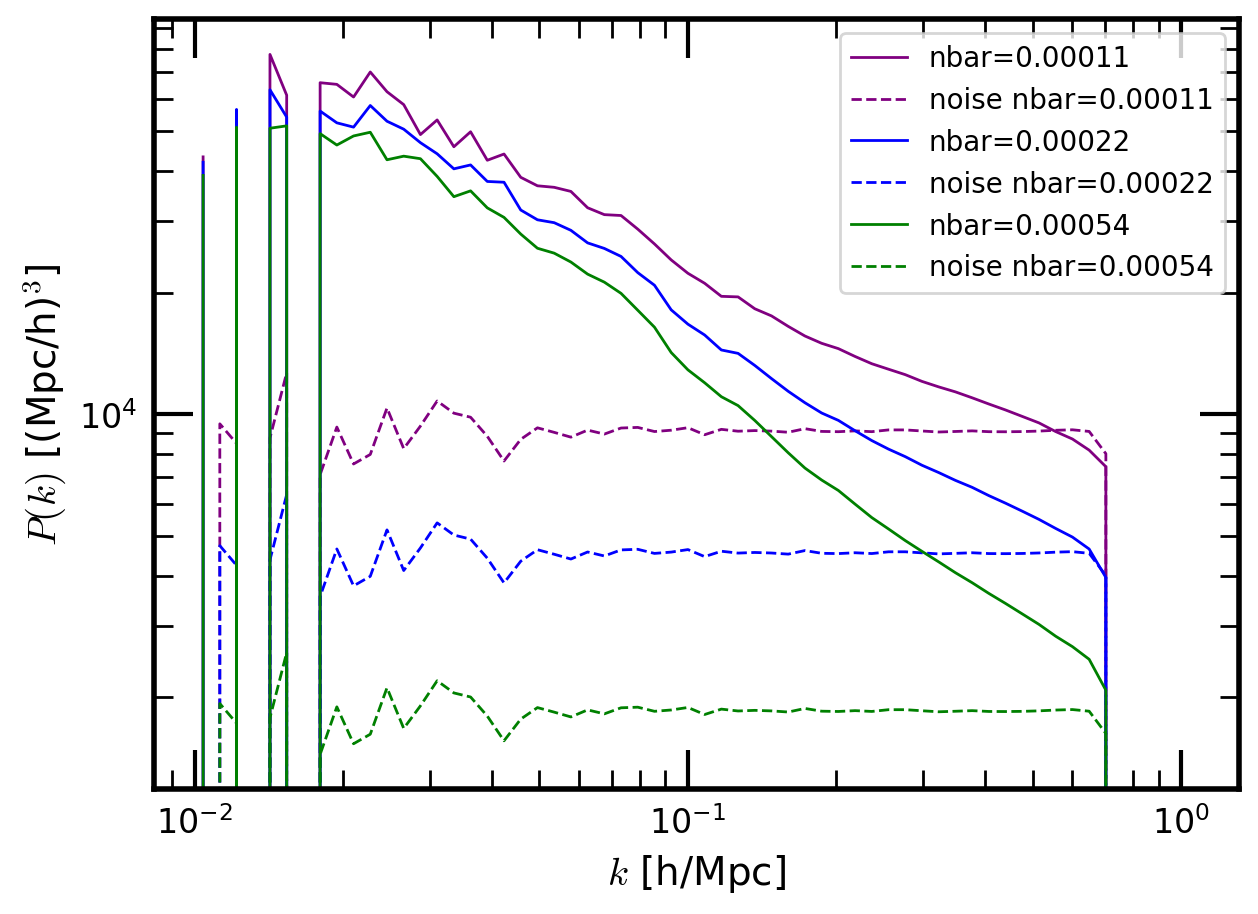

In [53]:
color_arr = ['purple', 'blue', 'green']
plt.figure(figsize=(7,5))
for i, tag_mock in enumerate(tags_mock):
    pk_obj = pk_obj_arr[i]

    plt.plot(pk_obj['k'], pk_obj['pk'], color=color_arr[i], label=f'nbar={nbar_arr[i]}', lw=1)
    plt.plot(pk_obj_noise_arr[i]['k'], pk_obj_noise_arr[i]['pk'], color=color_arr[i], ls='--', label=f'noise nbar={nbar_arr[i]}', lw=1)
    #plt.plot(pk_obj_noise_An_arr[i]['k'], pk_obj_noise_An_arr[i]['pk'], color=color_arr[i], ls=':', label=f'noise A*nbar={nbar_arr[i]}', lw=1)
    
    #plt.fill_between(pk_obj['k'], pk_obj['pk'] - pk_obj['pk_gaussian_error'], pk_obj['pk'] + pk_obj['pk_gaussian_error'], color='gray', alpha=0.5, label='gaussian error')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=10)